In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
import tqdm
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 10000)

In [2]:
@dataclass
class Cfg:
    exp_name = "eda001"
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")
cfg = Cfg()

In [3]:
train = pd.read_csv(cfg.input_dir + "train.csv")

In [4]:
train["event_name+fqid"] = train['event_name']+'_'+train['fqid']
train["even

In [26]:
[t for t in train["event_name+fqid"].dropna().unique() if "object_click_directory" in t]

['object_click_directory', 'object_click_directory.closeup.archivist']

In [11]:
events

['cutscene_click_intro',
 'person_click_gramps',
 'person_click_teddy',
 'navigate_click_teddy',
 'navigate_click_photo',
 'observation_click_photo',
 nan,
 'navigate_click_notebook',
 'object_click_notebook',
 'navigate_click_retirement_letter',
 'object_click_retirement_letter',
 'navigate_click_tobasement',
 'navigate_click_janitor',
 'observation_click_janitor',
 'navigate_click_toentry',
 'navigate_click_groupconvo',
 'cutscene_click_groupconvo',
 'object_hover_groupconvo',
 'object_click_report',
 'navigate_click_boss',
 'person_click_boss',
 'navigate_click_wells',
 'person_click_wells',
 'navigate_click_directory',
 'object_click_directory',
 'navigate_click_tocollection',
 'cutscene_click_cs',
 'navigate_click_tunic',
 'object_hover_tunic',
 'object_click_tunic',
 'object_click_tunic.hub.slip',
 'object_hover_tunic.hub.slip',
 'navigate_click_gramps',
 'navigate_click_tostacks',
 'navigate_click_outtolunch',
 'observation_click_outtolunch',
 'navigate_click_tocloset',
 'naviga

In [9]:
def quantile0_1(s):
    return s.quantile(0.1)
def quantile0_2(s):
    return s.quantile(0.2)
def quantile0_3(s):
    return s.quantile(0.3)
def quantile0_4(s):
    return s.quantile(0.4)
def quantile0_6(s):
    return s.quantile(0.6)
def quantile0_7(s):
    return s.quantile(0.7)
def quantile0_8(s):
    return s.quantile(0.8)
def quantile0_9(s):
    return s.quantile(0.9)

In [16]:
train.groupby("session_id")["elapsed_time"].agg(["max", "min", "quantile0_1"])

AttributeError: 'SeriesGroupBy' object has no attribute 'quantile0_1'

In [15]:
[c + "_" for c in ["max", "min", "quantile0_1"]]

['max_', 'min_', 'quantile0_1_']

In [5]:
train["hover_duration"].median()

419.0

In [7]:
np.nanmedian(train["hover_duration"].values)

419.0

In [3]:
train = pd.read_csv(cfg.input_dir + "train.csv")

# リプレイデータを除外する（level_groupの変化を積算し、3回を超えたレコードを除外）
train["level_group_change"] = (train["level_group"] != train.groupby("session_id")["level_group"].shift(1)).astype(int)
train["level_group_change_cumsum"] = train.groupby("session_id")["level_group_change"].cumsum()

train = train[train["level_group_change_cumsum"]<=3].reset_index(drop=True).drop(columns=["level_group_change", "level_group_change_cumsum"])

In [5]:
with open(cfg.prep_dir + 'cat_col_lists_v2.pkl', 'rb') as f:
    cat_col_lists = pickle.load(f) 


In [14]:
tmp

NameError: name 'tmp' is not defined

In [11]:
train[~train["hover_duration"].isnull()]["event_name"].value_counts()

object_hover    1053029
map_hover        941347
Name: event_name, dtype: int64

In [8]:
cat_col_lists["0-4"]["event_name+room_fqid"]

['cutscene_click_tunic.historicalsociety.closet',
 'person_click_tunic.historicalsociety.closet',
 'navigate_click_tunic.historicalsociety.closet',
 'observation_click_tunic.historicalsociety.closet',
 'notification_click_tunic.historicalsociety.closet',
 'object_click_tunic.historicalsociety.closet',
 'navigate_click_tunic.historicalsociety.basement',
 'observation_click_tunic.historicalsociety.basement',
 'navigate_click_tunic.historicalsociety.entry',
 'cutscene_click_tunic.historicalsociety.entry',
 'object_hover_tunic.historicalsociety.entry',
 'object_click_tunic.historicalsociety.entry',
 'person_click_tunic.historicalsociety.entry',
 'cutscene_click_tunic.historicalsociety.collection',
 'navigate_click_tunic.historicalsociety.collection',
 'object_hover_tunic.historicalsociety.collection',
 'object_click_tunic.historicalsociety.collection',
 'notification_click_tunic.historicalsociety.collection',
 'person_click_tunic.historicalsociety.collection',
 'navigate_click_tunic.histor

In [42]:
train["time_diff"] = train["elapsed_time"] - train.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

In [44]:
session_id = 20090312431273200

In [66]:
tmp[(tmp["event_name"]=="object_click")&(tmp["fqid"]=="gg")]["index"].values

array([], dtype=int64)

In [92]:
train["session_id"].unique()

array([20090312431273200, 20090312433251036, 20090312455206810, ...,
       22100217104993650, 22100219442786200, 22100221145014656])

In [105]:
group = "0-4"
def _add_minigame_features(start_fqid, end_fqid):
    game_name = start_fqid
    dfs = []
    for session_id in tqdm.tqdm(train["session_id"].unique()):
        tmp = train[train["session_id"]==session_id].copy()
        start_indexes = tmp[(tmp["event_name"]=="navigate_click")&(tmp["fqid"]==start_fqid)]["index"].values
        end_indexes = tmp[(tmp["event_name"]=="object_click")&(tmp["fqid"]==end_fqid)]["index"].values
        if len(start_indexes) > 0:
            start_index = start_indexes[0]
        else:
            start_index = np.nan
        if len(end_indexes) > 0:
            end_index = end_indexes[0]
        else:
            end_index = np.nan

        if start_index < end_index:
            mini_game_sessions = tmp[(tmp["index"]>start_index)&(tmp["index"]<=end_index)].copy()
            record_cnt = len(mini_game_sessions)
            total_duration = mini_game_sessions["time_diff"].sum()
            total_hover_duration = mini_game_sessions["hover_duration"].sum()

            hover_sessions = mini_game_sessions[mini_game_sessions["event_name"]=="object_hover"].copy()
            if len(hover_sessions) > 0:
                hover_cnt = len(hover_sessions)
            else:
                hover_cnt = 0

            click_sessions = mini_game_sessions[mini_game_sessions["event_name"]=="object_click"].copy()
            if len(click_sessions) > 0:
                click_cnt = len(click_sessions)
            else:
                click_cnt = 0

            feature_tmp = pd.DataFrame([[session_id, record_cnt, total_duration, total_hover_duration, hover_cnt, click_cnt]],
                                        columns=["session_id", f"{group}_{game_name}_record_cnt", f"{group}_minigame_{game_name}_total_duration", f"{group}_minigame_{game_name}_total_hover_duration",
                                                 f"{group}_{game_name}_hover_cnt", f"{group}_{game_name}_click_cnt"]
                                    )
        else:
            feature_tmp = pd.DataFrame([[session_id, 0, 0, 0, 0, 0]],
                                        columns=["session_id", f"{group}_{game_name}_record_cnt", f"{group}_minigame_{game_name}_total_duration", f"{group}_minigame_{game_name}_total_hover_duration",
                                                 f"{group}_{game_name}_hover_cnt", f"{group}_{game_name}_click_cnt"]
                                    )
        dfs.append(feature_tmp)
        if session_id == 20090312455206810:
            break
    return pd.concat(dfs, ignore_index=True)

In [106]:
_add_minigame_features("tunic", "tunic.hub.slip")

  0%|          | 2/23562 [00:00<10:12, 38.44it/s]


,session_id,0-4_tunic_record_cnt,0-4_minigame_tunic_total_duration,0-4_minigame_tunic_total_hover_duration,0-4_tunic_hover_cnt,0-4_tunic_click_cnt
0,20090312431273200,3,2170.0,400.0,1,2
1,20090312433251036,2,4819.0,701.0,1,1
2,20090312455206810,2,2349.0,0.0,0,1


In [107]:
_add_minigame_features("plaque", "plaque.face.date")

  0%|          | 2/23562 [00:00<10:44, 36.53it/s]


,session_id,0-4_plaque_record_cnt,0-4_minigame_plaque_total_duration,0-4_minigame_plaque_total_hover_duration,0-4_plaque_hover_cnt,0-4_plaque_click_cnt
0,20090312431273200,1,3168.0,0.0,0,1
1,20090312433251036,11,6635.0,80.0,2,9
2,20090312455206810,1,2166.0,0.0,0,1


In [108]:
_add_minigame_features("businesscards", "businesscards.card_bingo.bingo")

  0%|          | 2/23562 [00:00<10:18, 38.11it/s]


,session_id,0-4_businesscards_record_cnt,0-4_minigame_businesscards_total_duration,0-4_minigame_businesscards_total_hover_duration,0-4_businesscards_hover_cnt,0-4_businesscards_click_cnt
0,20090312431273200,10,8502.0,3001.0,6,4
1,20090312433251036,7,7718.0,1547.0,3,4
2,20090312455206810,5,4174.0,1318.0,1,4


In [109]:
_add_minigame_features("logbook", "logbook.page.bingo")

  0%|          | 2/23562 [00:00<10:45, 36.52it/s]


,session_id,0-4_logbook_record_cnt,0-4_minigame_logbook_total_duration,0-4_minigame_logbook_total_hover_duration,0-4_logbook_hover_cnt,0-4_logbook_click_cnt
0,20090312431273200,7,11175.0,450.0,2,5
1,20090312433251036,4,13100.0,1700.0,2,2
2,20090312455206810,3,3050.0,1212.0,2,1


In [111]:
_add_minigame_features("reader", "reader.paper2.bingo")

  0%|          | 2/23562 [00:00<10:13, 38.38it/s]


,session_id,0-4_reader_record_cnt,0-4_minigame_reader_total_duration,0-4_minigame_reader_total_hover_duration,0-4_reader_hover_cnt,0-4_reader_click_cnt
0,20090312431273200,6,7201.0,5117.0,3,3
1,20090312433251036,28,37250.0,3434.0,6,22
2,20090312455206810,5,6750.0,2900.0,1,4


In [112]:
_add_minigame_features("journals", "journals.pic_2.bingo")

  0%|          | 2/23562 [00:00<10:37, 36.94it/s]


,session_id,0-4_journals_record_cnt,0-4_minigame_journals_total_duration,0-4_minigame_journals_total_hover_duration,0-4_journals_hover_cnt,0-4_journals_click_cnt
0,20090312431273200,12,14551.0,4763.0,6,6
1,20090312433251036,48,42017.0,6111.0,14,34
2,20090312455206810,8,6153.0,2531.0,4,4


In [113]:
_add_minigame_features("tracks", "tracks.hub.deer")

  0%|          | 2/23562 [00:00<10:18, 38.10it/s]


,session_id,0-4_tracks_record_cnt,0-4_minigame_tracks_total_duration,0-4_minigame_tracks_total_hover_duration,0-4_tracks_hover_cnt,0-4_tracks_click_cnt
0,20090312431273200,3,4635.0,801.0,2,1
1,20090312433251036,7,9135.0,685.0,4,3
2,20090312455206810,1,1718.0,0.0,0,1


In [114]:
_add_minigame_features("reader_flag", "reader_flag.paper2.bingo")

  0%|          | 2/23562 [00:00<10:47, 36.39it/s]


,session_id,0-4_reader_flag_record_cnt,0-4_minigame_reader_flag_total_duration,0-4_minigame_reader_flag_total_hover_duration,0-4_reader_flag_hover_cnt,0-4_reader_flag_click_cnt
0,20090312431273200,6,9881.0,3217.0,1,5
1,20090312433251036,13,27818.0,4641.0,7,6
2,20090312455206810,6,9052.0,5635.0,3,3


In [115]:
_add_minigame_features("journals_flag", "journals_flag.pic_0.bingo")

  0%|          | 2/23562 [00:00<10:39, 36.85it/s]


,session_id,0-4_journals_flag_record_cnt,0-4_minigame_journals_flag_total_duration,0-4_minigame_journals_flag_total_hover_duration,0-4_journals_flag_hover_cnt,0-4_journals_flag_click_cnt
0,20090312431273200,6,5750.0,1184.0,4,2
1,20090312433251036,8,5520.0,1929.0,6,2
2,20090312455206810,10,14121.0,6020.0,8,2


In [58]:
pd.DataFrame([[1,2,3]],columns=["a", "b", "c"])

,a,b,c
0,1,2,3


In [52]:
feature_tmp = pd.DataFrame(columns=["session_id", f"{group}_{game_name}_record_cnt",
                                    f"{group}_{game_name}_total_duration", f"{group}_{game_name}_total_hover_duration",
                                    f"{group}_{game_name}_time_diff_mean", f"{group}_{game_name}_time_diff_std",
                                    f"{group}_{game_name}_hover_duration_mean", f"{group}_{game_name}_hover_duration_std",
                                    f"{group}_{game_name}_room_coor_x_mean", f"{group}_{game_name}_room_coor_x_std",
                                    f"{group}_{game_name}_room_coor_y_mean", f"{group}_{game_name}_room_coor_y_std"])

NameError: name 'group' is not defined

In [24]:
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [16]:
train[train["text_fqid"]=="tunic.historicalsociety.collection.tunic.slip"]["session_id"].value_counts()

21030414592393336    4
21010009584791444    4
21030212242444412    4
21030513030560944    3
22000508423577540    3
                    ..
21020215421470624    2
21020215390256284    2
21020215360091852    2
21020215331430452    2
22100221145014656    2
Name: session_id, Length: 23561, dtype: int64

In [13]:
train[train["text_fqid"]=="tunic.historicalsociety.collection.tunic"]["session_id"].value_counts()

22070119214956964    2
20110110103754420    2
20090312455206810    1
21090109322403344    1
21090020171980332    1
                    ..
21020309373839930    1
21020309380303092    1
21020309383576036    1
21020309420462144    1
22100221145014656    1
Name: session_id, Length: 12182, dtype: int64

In [19]:
tmp = train[train["session_id"]==20090312431273200].copy()

In [22]:
tmp

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991405,-157.314686,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485079,-199.971679,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355128,-168.619913,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733442,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048005,-153.743631,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


In [21]:
tmp[tmp["text_fqid"]=="tunic.historicalsociety.collection.tunic"].index

Int64Index([], dtype='int64')

In [7]:
train = pd.read_csv(cfg.prep_dir + "train0-4_cleaned.csv")

In [12]:
labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
old_labels = pd.read_csv(cfg.input_dir + "_old/train_labels.csv")

In [31]:
labels["session_id_ym"] = labels["session_id"].apply(lambda x: int(str(x)[:4]))

In [32]:
labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)

In [35]:
labels = labels.sort_values(["session_id_ym", "question"])

In [37]:
agg = labels.groupby(["session_id_ym", "question"])["correct"].mean().reset_index()

In [40]:
agg = agg.sort_values(["question", "session_id_ym"])

In [52]:
labels["session_id_ym"].value_counts()

2102    38214
2100    36576
2104    35856
2101    33696
2103    33048
2011    32598
2010    22896
2105    21744
2109    16758
2108    16614
2200    15066
2110    14436
2204    13032
2203    12816
2111    12636
2201    11304
2107     9756
2209     8694
2208     8388
2202     7164
2205     6444
2207     6012
2106     5922
2206     3654
2009      450
2210      342
Name: session_id_ym, dtype: int64

In [54]:
agg[agg["question"]==4]

,session_id_ym,question,correct
3,2009,4,0.840000
21,2010,4,0.784591
39,2011,4,0.773054
57,2100,4,0.802657
75,2101,4,0.795406
93,2102,4,0.802167
111,2103,4,0.794662
129,2104,4,0.800201
147,2105,4,0.807119
165,2106,4,0.805471


<AxesSubplot: >

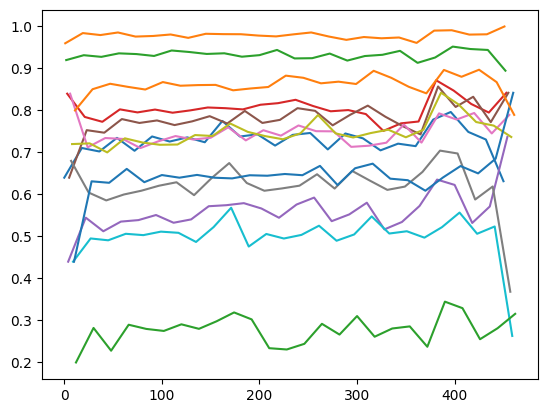

In [46]:
agg[agg["question"]==1]["correct"].plot()
agg[agg["question"]==2]["correct"].plot()
agg[agg["question"]==3]["correct"].plot()
agg[agg["question"]==4]["correct"].plot()
agg[agg["question"]==5]["correct"].plot()
agg[agg["question"]==6]["correct"].plot()
agg[agg["question"]==7]["correct"].plot()
agg[agg["question"]==8]["correct"].plot()
agg[agg["question"]==9]["correct"].plot()
agg[agg["question"]==10]["correct"].plot()
agg[agg["question"]==11]["correct"].plot()
agg[agg["question"]==12]["correct"].plot()
agg[agg["question"]==13]["correct"].plot()

In [22]:
labels[labels["train_test"]=="train"]["session_id_year"].value_counts()

21    136440
22     46998
20     28656
Name: session_id_year, dtype: int64

In [23]:
labels[labels["train_test"]=="test"]["session_id_year"].value_counts()

21    138816
22     45918
20     27288
Name: session_id_year, dtype: int64

In [15]:
old_labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


In [9]:
old_train = pd.read_csv(cfg.input_dir + "_old/train.csv", usecols=["session_id"])

In [7]:
old_train = 

21    17050318
22     5714730
20     3531898
Name: session_id_year, dtype: int64

In [4]:
sessions = train["session_id"].unique()
train[train["session_id"]==sessions[5]].to_csv("test.csv")

In [ ]:
tmp = train[train["session_id"]==20090312431273200]["text_fqid"].copy()

In [ ]:
tmp = tmp.fillna("nan")

In [ ]:
tmp

In [ ]:
train = pd.read_csv(cfg.input_dir + "train.csv")

In [ ]:
sessions = {}
sessions["text_fqid"] = train[train["session_id"]==20090312431273200]["text_fqid"].values

In [ ]:
sessions["text_fqid"][pd.isna(sessions["text_fqid"])] = "nan"


In [ ]:
sessions["text_fqid"]

In [ ]:
sessions["text_fqid"][1:]

In [ ]:
sessions["text_fqid"] == sessions["text_fqid"][1:]

In [ ]:
cat_col = "text_fqid"
tmp = train[["session_id", "level_group", cat_col]].copy()
tmp[cat_col] = tmp[cat_col].fillna("nan")
tmp[f"{cat_col}_change_cnt"] = (tmp[cat_col] != tmp.groupby(["session_id", "level_group"])[cat_col].shift(1)).astype(int)
add_features = tmp.groupby(["session_id", "level_group"])[f"{cat_col}_change_cnt"].sum().reset_index()

In [ ]:
tmp.head(1000)

In [ ]:
add_features

In [ ]:
train["room_fqid_change"] = (train["room_fqid"] != train.groupby(["session_id", "level_group"])["room_fqid"].shift(1)).astype(int)

In [ ]:
train.head(1000)[["room_fqid", "room_fqid_change"]]

In [ ]:
train["room_fqid"]. - self.sessions_df["elapsed_time"].shift(1).values

In [ ]:
train = train.sort_values(["session_id", "level_group", "index"], ignore_index=True)

In [ ]:
train

In [ ]:
train["time_diff"] = train["elapsed_time"] - train.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

In [ ]:
train["time_diff"]

In [ ]:
train["time_diff"] = np.where(train["time_diff"]<0, 0, train["time_diff"])
train["time_diff"] = np.nan_to_num(train["time_diff"], 0)

In [ ]:
sessions = train["time_diff"].values

In [ ]:
sessions = np.where(sessions<0, 0, sessions)
sessions = np.nan_to_num(sessions, 0)
sessions

In [ ]:
self.sessions[c] = self.sessions_df[c].values
        self.sessions["time_diff"] = self.sessions["elapsed_time"] - self.sessions_df["elapsed_time"].shift(1).values

In [ ]:
train["time_diff"]

In [ ]:
np.nan_to_num(train["time_diff"], 0)

In [ ]:
sessions = train["session_id"].unique()

In [ ]:
train[(train["session_id"]==sessions[5])].drop(columns=["session_id", "fullscreen", "hq", "music"]).to_csv("test.csv", index=False)

In [ ]:
oof = pd.read_csv(cfg.output_dir + "exp053/oof.csv.gz")

In [ ]:
oof

In [ ]:
sessions = {}
sessions["event_name"] = train["event_name"].values
sessions["fqid"] = train["fqid"].values 

In [ ]:
sessions["fqid"].tok + "_"

In [ ]:
cat_col = "fqid"
first_record = train.groupby(["session_id", "level_group", cat_col]).head(1)[["session_id", "level_group", cat_col, "room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].reset_index(drop=True)

In [ ]:
first_record[first_record["fqid"]=="intro"].drop(columns=["fqid"])

In [ ]:
["first_click"+val_name for val_name in ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]]

In [ ]:
train.groupby(["session_id", "fqid"]).head(1)[["session_id", "fqid"]+["room_coor_x", "room_coor_y"]]

In [ ]:
cat_col = "fqid"
cat = "test"
[f"{cat_col}_{cat}_first_click_{val_name}" for val_name in ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]]

In [ ]:
train["event_name"].unique()

In [ ]:
train["name"].unique()

In [ ]:
train["page"].unique()

In [ ]:
train["fqid"].unique()

In [ ]:
train["text_fqid"].unique()